In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class KalmanFilter:
    def __init__(self, sigma_x, sigma_q):
        sigma_v = 10.0
        self.sigma_x = sigma_x
        self.P = np.array([[sigma_x*sigma_x, 0.0, 0.0, 0.0], 
                           [0.0, sigma_x*sigma_x, 0.0, 0.0],
                           [0.0, 0.0, sigma_v*sigma_v, 0.0],
                           [0.0, 0.0, 0.0, sigma_v*sigma_v]])
        
        self.R = np.identity(2) * (sigma_x*sigma_x)
        self.is_init = False
        
    def predict(self, dt):
        A = np.array([[1.0, 0.0, dt, 0.0],
                      [0.0, 1.0, 0.0, dt],
                      [0.0, 0.0, 1.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0]])
        self.x = A.dot(self.x)
        A_t = np.transpose(A)
        '''
        Q = np.array([[pow(dt, 4)/4, 0.0, pow(dt, 3)/2, 0.0],
                      [0.0, pow(dt, 4)/4, 0.0, pow(dt, 3)/2],
                      [pow(dt, 3)/2, 0.0, pow(dt, 2), 0.0],
                      [0.0, pow(dt, 3)/2, 0.0, pow(dt, 2)]]) * self.sigma_x
        '''
        Q = np.zeros((4,4))
        self.P = A.dot(self.P).dot(A_t) + Q
    
    def update(self, measurement):
        H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
        
        PHt = self.P.dot(H.T)
        #print ('PHt =')
        #print (PHt)
        S = H.dot(PHt) + self.R
        #print ('S = ')
        #print (S)
        
        S_i = np.linalg.inv(S)
        #print ('S_i = ')
        #print (S_i)
        
        K = PHt.dot(S_i)
        #print ('K = ')
        #print (K)
        
        z = np.matrix(measurement).T
        #print ('z = ')
        #print (z)
        U = z - H.dot(self.x)
        #print ('U =')
        #print (U)
        self.x = self.x + K.dot(z - H.dot(self.x))
        I = np.identity(4)
        self.P = (I - K.dot(H)).dot(self.P)
        
    def process(self, measurement, dt):
        print ('-'*50)
        print ('measurement = ', measurement)
        if not self.is_init:
            self.x = np.array([[measurement[0]],[measurement[1]], [0.0], [0.0]])
            self.is_init = True
        else:
            print ('x = ')
            print (self.x)
            self.predict(dt)
            print ('x_predicted = ')
            print ( self.x)
            self.update(measurement)
        print ('x_ouput = ')
        print (self.x)
        print ('P =')
        print (self.P)

    def state(self):
        return self.x

    def covar(self):
        return self.P

In [14]:
sigma = .5
sigma_q = 0.3
v_x = 10.0
v_y = 4.0
dt = 1.0

x_actual = 10.0
y_actual = 0.0

kf = KalmanFilter(sigma, sigma_q)
no_iter = 100

measured_x = []
measured_y = []
actual_x = []
actual_y = []
position_x = []
position_y = []
vs_x = []
vs_y = []
covars_x = []
covars_y = []
t = range(no_iter)


for i in t:
    x_measured = random.gauss(x_actual, sigma)
    y_measured = random.gauss(y_actual, sigma)
    kf.process([x_measured, y_measured], dt)

    measured_x.append(x_measured - x_actual)
    measured_y.append(y_measured - y_actual)
    actual_x.append(x_actual)
    actual_y.append(y_actual)
    print ('state = ')
    print (kf.state())
    position_x.append(kf.state()[0][0] - x_actual)
    position_y.append(kf.state()[1][0] - y_actual)
    vs_x.append(kf.state()[2][0] - v_x)
    vs_y.append(kf.state()[3][0] - v_y)
    
    covars_x.append(kf.covar()[0][0])
    covars_y.append(kf.covar()[1][1])

    x_actual += v_x*dt
    y_actual += v_y*dt

--------------------------------------------------
measurement =  [10.872281459615161, 0.09096785569587007]
x_ouput = 
[[ 10.87228146]
 [  0.09096786]
 [  0.        ]
 [  0.        ]]
P =
[[   0.25    0.      0.      0.  ]
 [   0.      0.25    0.      0.  ]
 [   0.      0.    100.      0.  ]
 [   0.      0.      0.    100.  ]]
state = 
[[ 10.87228146]
 [  0.09096786]
 [  0.        ]
 [  0.        ]]
--------------------------------------------------
measurement =  [20.52431550493613, 3.928893243282975]
x = 
[[ 10.87228146]
 [  0.09096786]
 [  0.        ]
 [  0.        ]]
x_predicted = 
[[ 10.87228146]
 [  0.09096786]
 [  0.        ]
 [  0.        ]]
x_ouput = 
[[ 20.50030547]
 [  3.91934617]
 [  9.60401398]
 [  3.81883123]]
P =
[[ 0.24937811  0.          0.24875622  0.        ]
 [ 0.          0.24937811  0.          0.24875622]
 [ 0.24875622  0.          0.49751244  0.        ]
 [ 0.          0.24875622  0.          0.49751244]]
state = 
[[ 20.50030547]
 [  3.91934617]
 [  9.60401398]


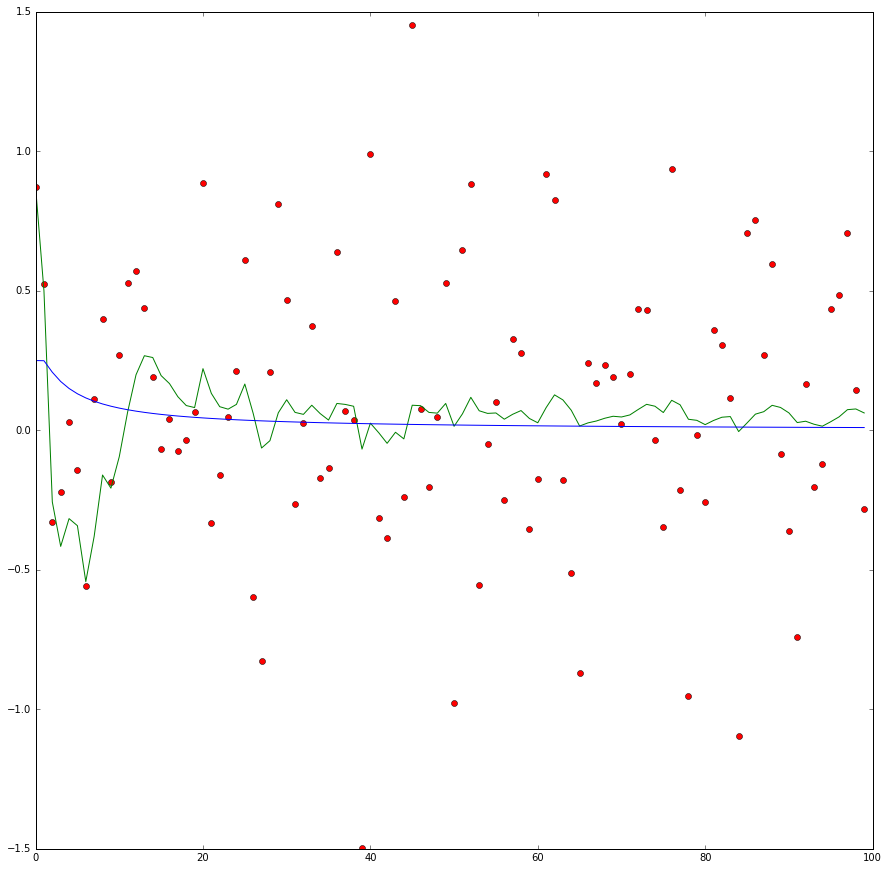

In [15]:
plt.figure(figsize=(15, 15))
plt.plot(t, measured_x, 'ro', t, position_x, 'g', t, covars_x, 'b')
plt.show()

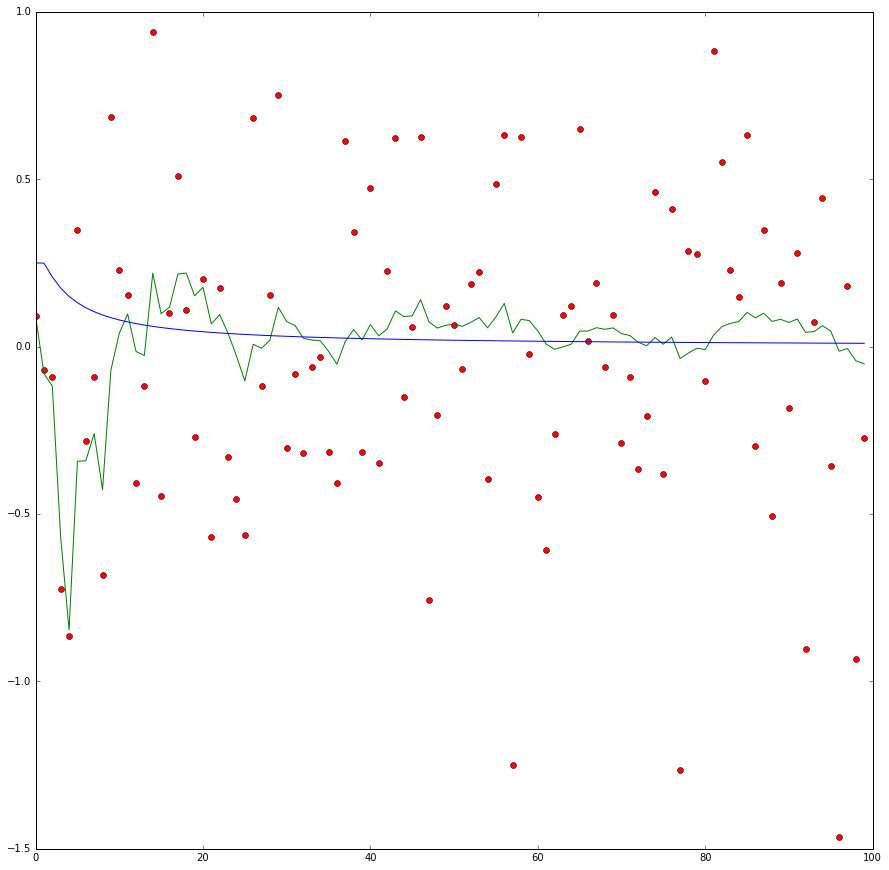

In [16]:
plt.figure(figsize=(15, 15))
plt.plot(t, measured_y, 'ro', t, position_y, 'g', t, covars_y, 'b')
plt.show()

In [20]:
print ('measured std_dev = ' , (np.sqrt(sum([x*x for x in measured_y])/len(measured_y))))
pos = position_y
print ('output std_dev = ' , (np.sqrt(sum([x*x for x in pos])/len(pos))))
print ('filter std_dev = ' , (np.sqrt(covars_y[-1])))

measured std_dev =  0.469858351034
output std_dev =  [[ 0.14434733]]
filter std_dev =  0.0992546468834
